# EXPLORATION_08 뉴스 요약봇 만들기

## Step 1. 데이터 수집하기

In [1]:
## 데이터 전처리를 위해서 패키지 불러오기~

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


=3


In [2]:
## 데이터는 뉴스 기사 데이터를 사용함!

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
89659,Hundreds of flyers miss flights over security ...,Hundreds of passengers at London Stansted Airp...
28382,Michael Jackson's father Joe passes away aged 89,Late 'King of Pop' Michael Jackson's father Jo...
88859,Singapore 'vending machine' dispenses Ferraris...,Autobahn Motors has opened a vending machine i...
81798,"Need Katrina in my life, she's a positive infl...","Actor Ranbir Kapoor, while talking about his r..."
77302,La Liga blocks Neymar's Ã¢ÂÂ¬222 million move...,La Liga has refused to accept a Ã¢ÂÂ¬222 mill...
12813,Nobody should interfere in beliefs: Rajini on ...,Talking about the controversy surrounding wome...
90355,Bus carrying I-League champions Aizawl FC fall...,A bus carrying newly-crowned I-League champion...
63574,India gives over 400 Pakistani minorities long...,The External Affairs Ministry has given over 4...
12038,FIFA Women's WC 2019 will have prize fund doub...,FIFA will raise the prize money for the Women'...
11219,Don't misappropriate GoT trademark for politic...,Responding to a Game of Thrones-inspired image...


데이터를 확인해보니 2가지 열이 text와 headlines로 구성되어 있는 것을 알 수 있다.

In [4]:
data = data[['text','headlines']]
data.head()

##랜덤한 15개 샘플 출력
data.sample(15)

,text,headlines
25126,Actor Nawazuddin Siddiqui is set to make his d...,Nawazuddin to debut in Tamil industry with Raj...
94260,"As per reports, actress Kim Sharma, who debute...",Kim Sharma bankrupt after separation from husb...
19580,Mumbai-based gift curation startup PropShop24 ...,Gifting startup PropShop24 gets Ã¢ÂÂ¹3.5 cr i...
72028,Over 40 lakh user records of Time Warner Cable...,40 lakh user records of Time Warner Cable expo...
11837,After Rakhi Sawant claimed that Tanushree Dutt...,Rakhi Sawant is a sex and money obsessed moron...
52526,Congress President Rahul Gandhi on Friday said...,Justice Loya's death must be investigated prop...
39768,Researchers are developing a blood test called...,Blood test to detect 10 cancers before symptom...
84752,"Mumbai authorities have seized 33,000 kg of a ...","33,000 kg of 'sex drug' smuggled into India fr..."
21811,Ex-Pakistani fast bowler Shoaib Akhtar used to...,"Akhtar threw rocks at mountains, bowled with t..."
58351,"Former boxing world champion Floyd Mayweather,...","Mayweather adopts baby giant panda, names it a..."


## Step 2. 데이터 전처리하기 (추상적 요약)

### 데이터 전처리하기 (1) 데이터 정리하기

#### 데이터의 중복 샘플을 제거하기!

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
## inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꾼다.
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
## 데이터 프레임에 Null값이 있는지 확인하기!

print(data.isnull().sum())

text         0
headlines    0
dtype: int64


In [8]:
## Null을 제거하고 다시 샘플 수 확인!

data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
## stopwords를 불용어라고 부른다.
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
## 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() ## 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text ## <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) ## 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) ## 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) ## 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) ## 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) ## 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) ## m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    ## 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    ## 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


전처리 전, 후 결과를 확인하기 위해서 임의의 text와 headlines을 만들어 함수를 호출한다.

In [12]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  ## 불용어를 제거하지 않는다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [13]:
clean_text = []
## 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

## 전처리 후 출력
## 일단 5개만 확인해보자~
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [14]:
clean_headlines = []
## 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [15]:
data['text'] = clean_text
data['headlines'] = clean_headlines

## 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [16]:
data.isnull().sum()

text         0
headlines    0
dtype: int64

In [17]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 데이터 전처리하기 (2)훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


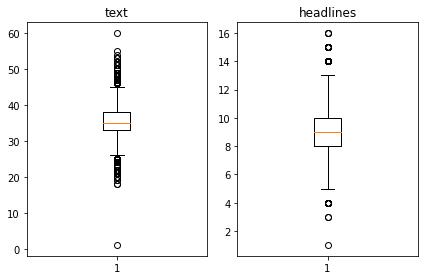

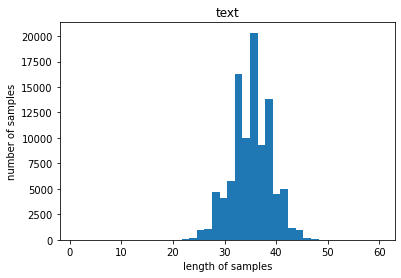

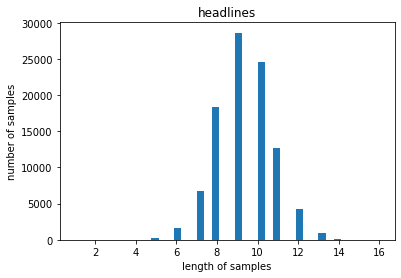

In [18]:
## 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
## 적절한 길이를 설정해줌
text_max_len = 50
headlines_max_len = 8
print('=3')

=3


In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [21]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


In [22]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 27105


### 시작토큰과 종료 토큰 추가하기

In [23]:
## 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,text,headlines,decoder_input,decoder_target
19,union minister dharmendra pradhan wednesday cl...,odisha cm patnaik controls mining mafia union ...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,indian space research organisation wednesday u...,isro unveils bengaluru centre for manned space...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,least people killed others injured saudi arabi...,killed injured in saudi arabia floods,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,investigators searching lost plane carrying ar...,seat cushions from missing plane carrying foot...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland chopper scam co accused rajiv s...,agustawestland scam accused rajiv saxena extra...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


토큰이 앞뒤로 잘 붙은 것을 확인이 가능함  
디코더의 입력과 레이블을 각각 다시 Numpy타입으로 저장해준다.

In [24]:
encoder_input = np.array(data['text']) ## 인코더의 입력
decoder_input = np.array(data['decoder_input']) ## 디코더의 입력
decoder_target = np.array(data['decoder_target']) ## 디코더의 레이블
print('=3')

=3


훈련데이터와 테스트데이터를 분리

In [26]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[  427  6679  7565 ...  1443 14960  2380]


In [27]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


In [28]:
## 데이터를 8:2 의 비율로 훈련 데이터와 테스트 데이터로 분리해준다.

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 5421


In [29]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


잘 나눠진 것을 알 수 있다!

### 데이터 전처리하기 (3) 정수 인코딩

In [30]:
src_tokenizer = Tokenizer() ## 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) ## 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다.

In [31]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42318
등장 빈도가 6번 이하인 희귀 단어의 수: 30632
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11686
단어 집합에서 희귀 단어의 비율: 72.3852734061156
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.273968136697485


토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [32]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) ## 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) ## 단어 집합 재생성
print('=3')

=3


In [33]:
## 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

## 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[230, 17, 5207, 163, 621, 1430, 21, 1855, 480, 224, 1017, 1092, 813, 1631, 406, 752, 795, 618, 49, 3600, 1683, 180, 1975, 1568, 3600, 916, 3327, 1395, 5, 113, 1823, 325, 1047, 168, 3328, 1], [5762, 169, 57, 945, 474, 157, 4519, 4898, 3698, 33, 5762, 169, 57, 32, 4652, 11, 26, 169, 622, 146, 5051, 226, 5763, 2552, 30, 88, 1799], [1591, 184, 7067, 3457, 69, 5764, 7, 2210, 412, 290, 130, 214, 793, 1250, 1824, 3457, 4069, 1569, 867, 4, 38, 917, 1132, 7068, 33, 95, 371, 1705, 5765, 214, 2017, 4171, 867]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오는 것을 확인할 수 있다.

In [34]:
## 전체 단어 집합과 각 단어에 대한 빈도수를 계산

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [35]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 ## 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 ## 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 ## 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

## 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    ## 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18890
등장 빈도가 5번 이하인 희귀 단어의 수: 14256
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4634
단어 집합에서 희귀 단어의 비율: 75.46850185283218
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.143559868466932


In [36]:
## 단어 집합의 크기를 제한
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

## 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

## 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 18, 888, 537, 59, 1320, 1081, 1801], [1, 160, 1802, 269, 23], [1, 729, 237, 5], [1, 3, 24, 1321], [1, 168, 21, 6, 217, 344, 31]]
target
decoder  [[18, 888, 537, 59, 1320, 1081, 1801, 2], [160, 1802, 269, 23, 2], [729, 237, 5, 2], [3, 24, 1321, 2], [168, 21, 6, 217, 344, 31, 2]]


In [37]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 9
삭제할 테스트 데이터의 개수 : 4
훈련 데이터의 개수 : 21675
훈련 레이블의 개수 : 21675
테스트 데이터의 개수 : 5417
테스트 레이블의 개수 : 5417


#### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했음 -> 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해서 같은 길이로 맞춰주는 패딩하기

In [38]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


#### 데이터 전처리 끝!!!!

## Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

In [39]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

## 인코더
encoder_inputs = Input(shape=(text_max_len,))

## 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

## 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

## 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

## 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [40]:
## 디코더 설계
decoder_inputs = Input(shape=(None,))

## 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

## 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [41]:
## 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

## 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

#### 어텐션 메커니즘   
#### 또 다른 새로운 신경망을 설계해야 한다는 뜻

In [42]:
from tensorflow.keras.layers import AdditiveAttention

## 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

## 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


## 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

## 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

## 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

#### 모델 훈련하기  
####  EarlyStopping 은 특정 조건이 충족되면 훈련을 멈춘다.

In [43]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)       ## EarlyStopping 은 특정 조건이 충족되면 훈련을 멈춘다.
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
85/85 [==============================] - 75s 690ms/step - loss: 4.9492 - val_loss: 4.4987
Epoch 2/50
85/85 [==============================] - 59s 693ms/step - loss: 4.5394 - val_loss: 4.3058
Epoch 3/50
85/85 [==============================] - 59s 698ms/step - loss: 4.3463 - val_loss: 4.1635
Epoch 4/50
85/85 [==============================] - 59s 699ms/step - loss: 4.1995 - val_loss: 4.0825
Epoch 5/50
85/85 [==============================] - 59s 690ms/step - loss: 4.0647 - val_loss: 3.9384
Epoch 6/50
85/85 [==============================] - 58s 688ms/step - loss: 3.9385 - val_loss: 3.8473
Epoch 7/50
85/85 [==============================] - 58s 682ms/step - loss: 3.8138 - val_loss: 3.7670
Epoch 8/50
85/85 [==============================] - 58s 685ms/step - loss: 3.6803 - val_loss: 3.6656
Epoch 9/50
85/85 [==============================] - 59s 689ms/step - loss: 3.5519 - val_loss: 3.5684
Epoch 10/50
85/85 [==============================] - 60s 700ms/step - loss: 3.4376 - val_lo

#### 훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화하기

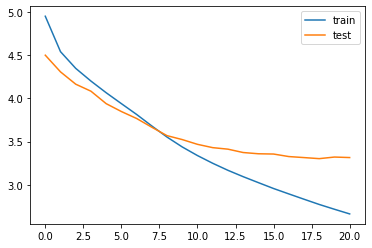

In [44]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [52]:
src_index_to_word = src_tokenizer.index_word ## 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index ## 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word ## 요약 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


In [53]:
## 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

## 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

## 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
## 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [54]:
## 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

## 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

## 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [58]:
def decode_sequence(input_seq):
    ## 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     ## <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: ## stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        ##  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        ## 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        ## 상태를 업데이트 한다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [59]:
## 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

## 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

print('=3')

=3


In [60]:
## 테스트 데이터 약 50개의 샘플에 대해서 실제 요약과 예측된 요약을 비교
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : many residents forced us city due started monday called fire contained spread acres fire department said helicopters aircraft firefighters deployed blaze added 
실제 요약 : evacuated due to in us 
예측 요약 :  found in china


원문 : hollywood actor tom cruise got hurt shooting stunt upcoming film mission impossible video shows actor jumping two buildings assistance missing edge second roof building later seen collapsing near crew members 
실제 요약 : cruise gets injured while for 
예측 요약 :  actress shares pic of


원문 : china law appropriate use national anthem introducing criminal prosecution state media reported lyrics could reportedly face criminal prosecution detention days draft legislation also made illegal use national anthem inappropriate private occasions 
실제 요약 : china law against of national anthem 
예측 요약 :  saudi arabia to ban


원문 : english fan ed teacher profession travelled four months visited countries reach watch first ashes test crossed kilometres without taking single flight t

## Step 5. Summa을 이용해서 추출적 요약해보기

### 패키지 설치 & 데이터 다운로드하기

In [77]:
import requests
from summa.summarizer import summarize

In [78]:
News = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
News['text']

0        Saurav Kant, an alumnus of upGrad and IIIT-B's...
1        Kunal Shah's credit card bill payment platform...
2        New Zealand defeated India by 8 wickets in the...
3        With Aegon Life iTerm Insurance plan, customer...
4        Speaking about the sexual harassment allegatio...
                               ...                        
98396    A CRPF jawan was on Tuesday axed to death with...
98397    'Uff Yeh', the first song from the Sonakshi Si...
98398    According to reports, a new version of the 199...
98399    A new music video shows rapper Snoop Dogg aimi...
98400    Madhesi Morcha, an alliance of seven political...
Name: text, Length: 98401, dtype: object

In [79]:
for idx, text in enumerate(news_data['text'][:10]):
    print(f'<Original_{idx+1}:> \n{text}')
    print(f'[Summary:] \n{summarize(text, words=20)}\n')

<Original_1:> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
[Summary:] 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

<Original_2:> 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
[Summary:] 
Users get one CRED coin per r

In [80]:
print(text[:1500])

Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll. With this victory, Congress has taken its total to 100 seats in the 200-member assembly. The election to the Ramgarh seat was delayed due to the death of sitting MLA and BSP candidate Laxman Singh.


### summarize 사용하기

In [84]:
print('Summary:')
print(summarize(text, ratio=0.5))

Summary:
Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll.


In [85]:
print('Summary:')
print(summarize(text, ratio=0.5, split=True))

Summary:
["Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll."]


In [86]:
print('Summary:')
print(summarize(text, words=50))

Summary:
Congress candidate Shafia Zubair won the Ramgarh Assembly seat in Rajasthan, by defeating BJP's Sukhwant Singh with a margin of 12,228 votes in the bypoll.
The election to the Ramgarh seat was delayed due to the death of sitting MLA and BSP candidate Laxman Singh.


# 회고!

## < 어려웠던 점>  
음 이번에는 추상적 요약과 추출적 요약을 나눠서 해보았는데 그 용어조차 제대로 몰랐어서 그것부터 찾아봤다. 그리고 모델을 훈련하는 과정에서 epochs이 50이라서 처음에 엄청 당황했었다...EarlyStopping 을 사용하면 특정 조건이 충족되면 훈련을 멈춘다고 해서 다행이었다. 그래도 훈련을 시키는데 시간이 꽤 소비되었던 것 같다. 그리고 마지막 추출적 요약을 하는 과정에서 생각을 조금 했어야 해서 구글링을 열심히 보았다.

## < 알아낸 점> & < 아직까지 모호한 점>  
추상적 요약은 ! 원문으로부터 내용이 요약된 새로운 문장을 생성해내는 것이다. 반대로 추출적 요약은 단어 그대로 원문에서 문장들을 추출해서 요약하는 방식이다. EarlyStopping이 있는 것도 처음 알게되었다. epochs이 50이었는데 중간에 멈추길래 놀랬는데 알고보니 EarlyStopping 이 있어서 그랬던 것 같다. 그리고 인코딩과 디코딩을 저번에 배우긴 했지만 모델을 설계하는 과정에서 조금 더 알게 되었던 것 같다.

## < 자기 다짐>  
nlp 하기전에는 항상 막막하게 시작을 했던 적이 많았던 것 같다. 하지만 이번꺼는 시간이 설 덕분에 시간이 넉넉했다. 그래서 시간을 넉넉하게 가지고 찾아보면서 진행하니까 뭔가 재밌었던 것 같다. 데이터 처리도 여러가지 방법이 있고 모델도 여러가지 다양하게 알아본 것 같다. 하기전에 못할 것 같다는 마음을 빼고 일단 해봐야겠다... 화이팅...!!